# Indoor HIIT 健身动作识别算法的开发与部署

## Introduction
**此notebook 介绍了一种基于手机内置传感器的健身动作识别算法的开发及部署过程。此算法的功能是根据手机内置加速度与角速度传感器获取的数据判断使用者当前的动作。经过对比不同模型在验证集上的表现，选择一维CNN网络直接处理原始数据，而不进行特征提取。算法在测试集上的的平均准确率为97.7% 部署阶段，实用Tensorflow Serving 将模型部署至服务器。并使用Flask Web框架搭建API服务接口，以供微信小程序调用并返回预测结果。**
<img src="https://s1.ax1x.com/2020/06/16/NiouQA.png" alt="NiouQA.png" border="0" width=70%/>


## 1.数据收集

### 1.1 Activities
* **徒手侧平举**
* **前后交叉小跑**
* **开合跳**
* **深蹲**


###  1.2 Format
  * **在1次采集中，使用者左手持手机，并连续做同一动作20s。 传感器取样率为50Hz，20ms采集一次数据。 小程序将收集到的数据以json格式发送至云服务器。**
  * **采集阶段，有超过10位用户参与，每位用户都进行了4个动作的数据采集。为了保证算法的可泛化，除规定手持手机姿势外，不对用户设置其他规定。**
  * **数据字段如下**
  
  
| Data                    | Key words | Type   |
| ----------------------- | --------- | ------ |
| Acceleration X axis     | accx      | Array  |
| Acceleration Y axis     | accy      | Array  |
| Acceleration Z axis     | accz      | Array  |
| Angular velocity X axis | gyrx      | Array  |
| Angular velocity Y axis | gyry      | Array  |
| Angular velocity Z axis | gyrz      | Array  |
| UserID                  | Id        | string |
| Number of actions       | number    | Int    |
| Class of activity       | Activity  | Int    |
|                         |           |        |

 * **所有数据均正常，且无缺失值**
 * **数据还包括用户的性别、身高、体重等信息。为使模型更好的泛化，仅选取六轴数据**
  

## 2. 数据加载与预处理

* **原始6轴数据存在较大的噪音，在训练算法之前，先将数据进行滤波，除去高频噪音。滤波器使用低通巴特沃滋滤波器**
* **将数据分割为2.56s的窗口（128个数据点）其中窗口之间有50%的重合.**
<img src="https://s1.ax1x.com/2020/06/17/NVv0mV.png" alt="NVv0mV.png" border="0" width=50% />

* **使用Python中的json包读取原始数据json文件，并将其转化为nmupy数组**
* **在使用多元时间序列数据时，将数据结构化为以下格式：**
 [samples, timesteps, channels] 此处为 [1470,128,6]

In [2]:
import json
import IPython
import sys
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
from scipy import signal,fft
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [10]:
b, a = signal.butter(8, 0.2, 'lowpass') #initialize the filter
file=["/root/HAR/data/ios519/activity1.json",
      "/root/HAR/data/ios519/activity2.json",
      "/root/HAR/data/ios519/activity3.json",
      "/root/HAR/data/ios519/activity4.json",
      ]#file path
total_data=[]
label=[]
for filepath in file:
    with open(filepath) as f:
        for line in f:# lines by lines
            one= json.loads(line)
            
            for i in range(15):# 
                accx=signal.filtfilt(b, a,one["accx"][50+i*64:i*64+178])#each window has 128 observations
                accy=signal.filtfilt(b, a,one["accy"][50+i*64:i*64+178])#and 50% overlap
                accz=signal.filtfilt(b, a,one["accz"][50+i*64:i*64+178])
                gryx=signal.filtfilt(b, a,one["gryx"][50+i*64:i*64+178])
                gryy=signal.filtfilt(b, a,one["gryy"][50+i*64:i*64+178])
                gryz=signal.filtfilt(b, a,one["gryz"][50+i*64:i*64+178])
                activity=one["activity"]                
                
                data=np.dstack((accx,accy,accz,gryx,gryy,gryz)).reshape((128,6))#128 datapoints with 6 channels
                total_data.append((data,activity))
            
print("We have" ,np.array(total_data).shape[0] ,"rows or windows of data, each window has 128 observations with 6 channels")




We have 1470 rows or windows of data, each window has 128 observations with 6 channels


### 2.1分割数据集
**我们将整个数据集分为：训练集(60%)、验证集(20%)、测试集(20%)**


* **训练集：仅用于模型训练**
* **验证集：根据训练所得模型在验证集上的表现，调整参数、超参数。以获得最佳表现**
* **测试集：仅用于最终模型测试**

<img src="https://s1.ax1x.com/2020/06/16/NkYHMR.png" alt="NkYHMR.png" border="0" width=60% />


In [48]:
np.random.seed(22)
np.random.shuffle(total_data)#！！！ shuffle the data （important）
train=total_data[0:1176]#60%
val=total_data[1176:1323]#20%
test=total_data[1323:1471]#20%
test_data=[]
test_label=[]
train_data=[]
train_label=[]
val_data=[]
val_label=[]

for i in range(len(test)):
    test_data.append(test[i][0])
    test_label.append([test[i][1]])
for i in range(len(train)):
    train_data.append(train[i][0])
    train_label.append([train[i][1]])
for i in range(len(val)):
    val_data.append(val[i][0])
    val_label.append([val[i][1]])
test_data=np.array(test_data)
test_label=np.array(test_label)
train_data=np.array(train_data)
train_label=np.array(train_label)
val_data=np.array(val_data)
val_label=np.array(val_label)
print("Train data shpae is ",train_data.shape,)
print("Train label shpae is ",train_label.shape,)
print("Validation data shpae is ",val_data.shape,)
print("Validation label shpae is ",val_label.shape,)
print("Test data shpae is ",test_data.shape,)
print("Test label shpae is ",test_label.shape,)

Train data shpae is  (1176, 128, 6)
Train label shpae is  (1176, 1)
Validation data shpae is  (147, 128, 6)
Validation label shpae is  (147, 1)
Test data shpae is  (147, 128, 6)
Test label shpae is  (147, 1)


###  2.1 数据集的分布
**为了确保模型可以平均学习到4种动作的特征，必须确保训练集中4中动作的数据占比相似**

**为了确保模型测试符合实际使用时情况，要是 验证集和测试集 4种动作占比相似**

In [49]:
def class_breakdown(data):
    # convert the numpy array into a dataframe
    df = pd.DataFrame(data)
# group data by the class value and calculate the number of rows
    counts = df.groupby(0).size()
# retrieve raw rows
    counts = counts.values
# summarize
    for i in range(len(counts)):
        percent = counts[i] / len(df) * 100
        print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))


In [50]:
print("Train set:")
class_breakdown(train_label)
print("Validation set:")
class_breakdown(val_label)
print("Test set:")
class_breakdown(test_label)

Train set:
Class=1, total=360, percentage=30.612
Class=2, total=265, percentage=22.534
Class=3, total=281, percentage=23.895
Class=4, total=270, percentage=22.959
Validation set:
Class=1, total=50, percentage=34.014
Class=2, total=30, percentage=20.408
Class=3, total=30, percentage=20.408
Class=4, total=37, percentage=25.170
Test set:
Class=1, total=40, percentage=27.211
Class=2, total=35, percentage=23.810
Class=3, total=34, percentage=23.129
Class=4, total=38, percentage=25.850


**可以看到，4种动作在3个集上的分布较为平均 可以进行模型训练与测试**

## 3. 特征选择与提取
**标准分类算法不能直接应用于原始时间序列加速度计数据。相反，我们首先必须将原始时间序列数据转换为某些特征。我们将数据划分为2.56s的窗口，然后基于每个2.56秒的段中包含的128$\times$6个读数生成特征。**


**由于现有的数据为2.56s窗口内三轴加速度与三轴角速度，首先选择在时域上进行特征提取。 经过多次实验，比较不同特征对算法准确率的影响。选取特征为：**

* **最大值**
* **最小值**
* **标准差**
* **平均值**
* **中位数**
* **绝对中位差**

**共提取36个特征. 用提取后的特征训练的SVM与Random Forest 分类器均有较好的表现**


In [51]:
def feature_extratction(raw_data):#function to extract features
    Total_feature_data=[]
    sample_num=raw_data.shape[0]
    length=raw_data.shape[1]
    channels=raw_data.shape[2]
    for i in range(sample_num):
        feature_arrray=[]
        for j in range(channels):            
            data_array=raw_data[i,:,j]
            Max=np.max(data_array)
            Min=np.min(data_array)
            Avg=np.mean(data_array)
            Mad=Series(data_array).mad()
            Median=np.median(data_array)
            Std=Series(data_array).std()
            feature_arrray.extend([Max,Min,Avg,Mad,Median,Std])
        Total_feature_data.append(feature_arrray)
           
    return np.array(Total_feature_data)

In [52]:
Train_feature_data=feature_extratction(train_data)
Val_feature_data=feature_extratction(val_data)
Test_feature_data=feature_extratction(test_data)

## 4. 选择模型

**在这个任务中，我们所需要的模型应能够正确的通过2.56s内手机六轴的数据，识别出用户所做的动作。 我们希望看到模型可以尽可能多的识别出用户当前的动作。所以选择算法时，我们关心模型在测试集上的精确率(precision)与召回率（recall）。为了实现单一指标选择。我们引入二者的调和平均F-1 score作为判断指标**


**实际部署中，时间也是需要考虑的因素。此处所选取的算法所需的预测时间均较短且无较大差别，故不将其计入判断指标**

**在现有的研究中，SVM模型与Random forest模型在使用传感器的人体动作识别任务上有最优的表现<sup>1<sup>** 
    
**在实际实验中，一维CNN网络在测试集上的表现最优。**


### 4.1 SVM
**SVM模型本身是一个二值分类器，再多分类问题上，使用一对一法（one-versus-one）两两类之间构造1个分类器，在这个任务中共有4种分类，6个SVM分类器（one-against-one）**

In [16]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score

**实验过程为选取不同的训练参数，用训练集训练模型并检查在验证集上的表现。 目的为找出在验证集上表现最优的训练参数**



**实验结果为：C=1 Kernel=RBF函数 tolerate=0.001**

In [53]:
X = Train_feature_data
Y = np.squeeze(train_label)

clf = SVC(C=1.0,  class_weight=None,
    decision_function_shape='ovo',  gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
clf.fit(X, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#### Confusion Matrix & F1 Score

In [126]:
y_pred_svm=clf.predict(Test_feature_data)
y_real=np.squeeze(test_label)


0.9661620966845589

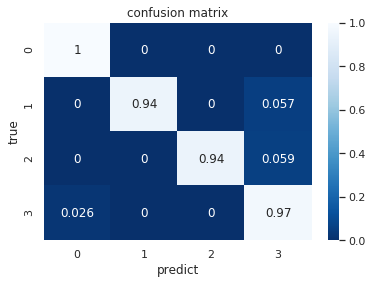

In [80]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
C_svm=confusion_matrix(y_real, y_pred_svm,labels=[1,2,3,4])
sns.set()
f,ax=plt.subplots()
C_svm = C_svm.astype('float') / C_svm.sum(axis=1)[:, np.newaxis] #normalize the confusion matrix
sns.heatmap(C_svm,annot=True,ax=ax,cmap="Blues_r") #plot the matrix

ax.set_title('confusion matrix') #set title
ax.set_xlabel('predict') # X label
ax.set_ylabel('true') #Y label


**SVM分类器的F1 score**

In [144]:
f1_svm=f1_score(y_real,y_pred_svm,labels=[1,2,3,4],average='macro')
print("F1 score:",f1_svm)

F1 score: 0.9661620966845589


### 4.2 Random Forest
**随机森林在很多分类问题上表现良好，它是Bagging算法的特例，通过构建多棵分类树。每棵树生成一个分类结果，由投票法决定最终分类**

**经过实验，随机森林算法在测试集上平均正确率均在95%以上。 以下为实验过程中准确率最高一组**

In [123]:
from sklearn.ensemble import RandomForestClassifier

In [124]:
np.random.seed(6)
rfc = RandomForestClassifier()
rfc = rfc.fit(X, Y)
y_pred_rfc=rfc.predict(Test_feature_data)
y_real=np.squeeze(test_label)



/root/anaconda3/envs/jupyter_notebook/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


#### Confusion Matrix & F1 Score

Text(30.5, 0.5, 'true')

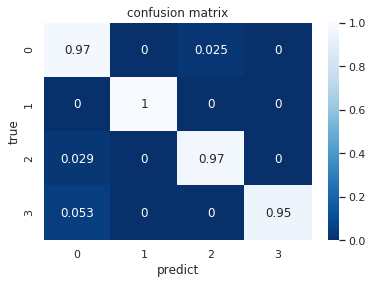

In [125]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
C_rfc=confusion_matrix(y_real, y_pred_rfc,labels=[1,2,3,4])
sns.set()
f,ax=plt.subplots()
C_rfc = C_rfc.astype('float') / C_rfc.sum(axis=1)[:, np.newaxis] #normalize the confusion matrix
sns.heatmap(C_rfc,annot=True,ax=ax,cmap="Blues_r") #plot the matrix

ax.set_title('confusion matrix') #set title
ax.set_xlabel('predict') # X label
ax.set_ylabel('true') #Y label

**Random Forest分类器的F1 score**

In [145]:
f1_rfc=f1_score(y_real_test,y_pred_rfc,labels=[1,2,3,4],average='macro')
print("F1 score :" ,f1_rfc)

F1 score : 0.9736951801155531


### 4.3 CNN
**深度学习方法 已被证明可以在极少的数据特征工程或没有数据特征工程的情况下，提供具有挑战性的活动识别任务的最新结果[<sup>2</sup>](#refer-anchor-2)** **.在识别健身动作中，选取特征时需要进行多次实验，往往不能很快找到最佳特征。为此，我们引入一维卷积神经网络（CNN）处理时间序列数据。并自动学习其中的特征[<sup>3</sup>](#refer-anchor-3)**。 **进过多次调整CNN的不同参数、超参数。 我们得到了一个令人惊喜的结果**


**神经网络表现往往优于普通机器学习算法[<sup>4</sup>](#refer-anchor-4)**

<img src="https://s1.ax1x.com/2020/06/18/Ne1WV0.png" alt="截屏2020 06 18 下午12.37.21" border="0" width=70%>

**一维卷积神经网络（CNN）处理六轴数据[<sup>3</sup>](#refer-anchor-3)**
<img src="https://s1.ax1x.com/2020/06/18/Nei81O.png" alt="截屏2020 06 17 下午7.52.20" border="0" width=70%>


#### One-Hot 向量
**网络输出为长度为4的1位数组，4个数分别代表输入数据 被识别为四种动作的概率。 为训练网络及检验结果，我们将原有的label分类变为 one-hot向量的格式**

In [59]:
def change(data_label):
    m,n=data_label.shape[0],data_label.shape[1]
    data_label_onehot=np.zeros((m,n,4))
    for l in range(m):
        if data_label[l]== [1.0]:
            data_label_onehot[l]=[[1,0,0,0]]
        elif data_label[l]== [2.0]:
            data_label_onehot[l]=[[0,1,0,0]]
        elif data_label[l]== [3.0]:
            data_label_onehot[l]=[[0,0,1,0]]
        elif data_label[l]== [4.0]:
            data_label_onehot[l]=[[0,0,0,1]]
    return np.array(data_label_onehot)    

In [60]:
train_label_onehot=change(train_label)
test_label_onehot=change(test_label)
val_label_onehot=change(val_label)

**整个网络由4个卷基层，2个Dropout层，2个全连接层组成。实验中，随着卷基层数的增加，模型在验证集上的表现不断提升。通过调整每一层的参数，最终得到了一个表现良好的网络。其最大的优点是可以直接处理时间序列数据，进行自动特征提取并识别分类[<sup>5</sup>](#refer-anchor-5)
。**
* **卷基层（Conv layer）：自动特征提取**
* **Dropout层： 防止过拟合（overfitting）**
* **全联接层（FC layer）：预测结果**

<img src="https://s1.ax1x.com/2020/06/18/Nei39K.png" alt="截屏2020 06 17 下午9.38.15" border="0" width=30%>

In [ ]:
import tensorflow as tf
from keras import backend as K
from keras.models import load_model, Model,Input
from keras.layers import Conv1D,Dense,ZeroPadding1D,MaxPooling1D,AveragePooling1D,Dropout

In [8]:
def HARmodel(input_shape):
    X_input = Input(input_shape)
    X=Conv1D(32,5,strides=1,activation='relu',name="Conv1D_1")(X_input)
    #X=AveragePooling1D(pool_size=1,strides=2, padding='valid')(X)
    X=Conv1D(64,5,strides=2,activation='relu',name="Conv1D_2")(X)
    #X=MaxPooling1D(pool_size=1,strides=1, padding='valid')(X)
    #X=ZeroPadding1D(padding=2)(X)
    X=Conv1D(64,5,strides=4,activation='relu',name="Conv1D_3")(X)
    #X=MaxPooling1D(pool_size=2,strides=3, padding='valid')(X)
    X=Conv1D(64,5,strides=16,activation='relu',name="Conv1D_4")(X)
    X=Dropout(0.5)(X)
    #X=MaxPooling1D(pool_size=1,strides=2, padding='valid')(X)
    X = Dense(128, activation='softmax', name='FC_1_softmax')(X)
    X=Dropout(0.5)(X)
    X = Dense(4, activation='softmax', name='FC_2_softmax')(X)
    model = Model(inputs = X_input, outputs = X, name='HARModel')
    return model

In [9]:
harModel = HARmodel(train_data.shape[1:])

**由于此任务为多分类问题，loss function选为CrossEntrop，优化器选为Adam，可以加快收敛速度。 具体超参数为 learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,**

In [10]:
harModel.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

**训练过程中，训练次数选为1500次，用Mini-batch的方式训练，batch size选为200**

In [ ]:

history=harModel.fit(train_data,train_label_onehot, epochs = 1500, batch_size = 200,validation_data=(val_data,val_label_onehot))

#### 训练过程的正确率曲线

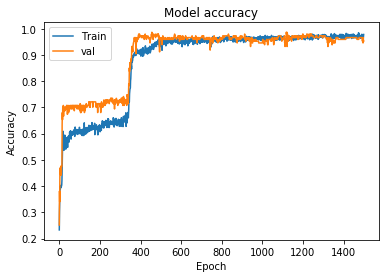

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc='upper left')
plt.show()

#### 训练过程的loss曲线

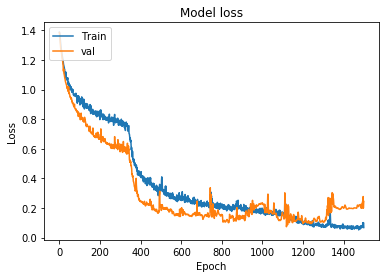

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc='upper left')
plt.show()

**保存训练好的模型**

In [14]:
#harModel.save("/root/HAR/data/ConvNet_v5_new.h5")

**读取模型**

In [135]:
harModel=load_model("/root/HAR/data/ConvNet_v3_new.h5")

**评估模型，查看模型在测试集上的平均正确率与损失**

In [136]:
preds =harModel.evaluate(x = test_data, y = test_label_onehot)
print ("Model loss is",preds[0])
print ("Model accuracy is",preds[1])

147/147 [==============================] - 0s 2ms/step
Model loss is 0.07067668966340776
Model accuracy is 0.9931972622871399


In [16]:
from sklearn.metrics import confusion_matrix

In [129]:
y_pred_raw=harModel.predict(test_data)
zzz=np.squeeze(y_pred_raw)#np.argmax(yy,1)
y_pred_cnn=list(np.argmax(zzz,1)+1)

In [130]:
y_true=list(np.squeeze(test_label))

In [137]:
from sklearn.metrics import confusion_matrix
C=confusion_matrix(y_true, y_pred_cnn,labels=[1,2,3,4])


Text(30.5, 0.5, 'true')

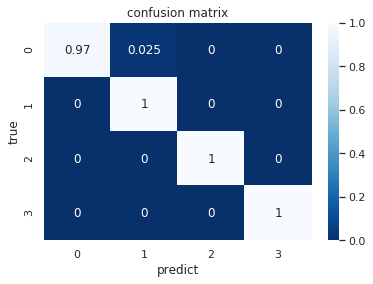

In [138]:
import seaborn as sns
sns.set()
f,ax=plt.subplots()
C = C.astype('float') / C.sum(axis=1)[:, np.newaxis] #normalize the confusion matrix
sns.heatmap(C,annot=True,ax=ax,cmap="Blues_r") #plot the matrix

ax.set_title('confusion matrix') #set title
ax.set_xlabel('predict') # X label
ax.set_ylabel('true') #Y label

In [139]:
f1_cnn=f1_score(tru,ttt,labels=[1,2,3,4],average='macro')
print("F1 score is ",f1_cnn)

F1 score is  0.9933143162774113


**算法每一层的详细信息**

In [140]:
harModel.summary()

Model: "HARModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 6)            0         
_________________________________________________________________
Conv1D_1 (Conv1D)            (None, 124, 32)           992       
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 60, 64)            10304     
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 14, 64)            20544     
_________________________________________________________________
Conv1D_4 (Conv1D)            (None, 1, 64)             20544     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
fc4 (Dense)                  (None, 1, 128)            832

**算法流程**

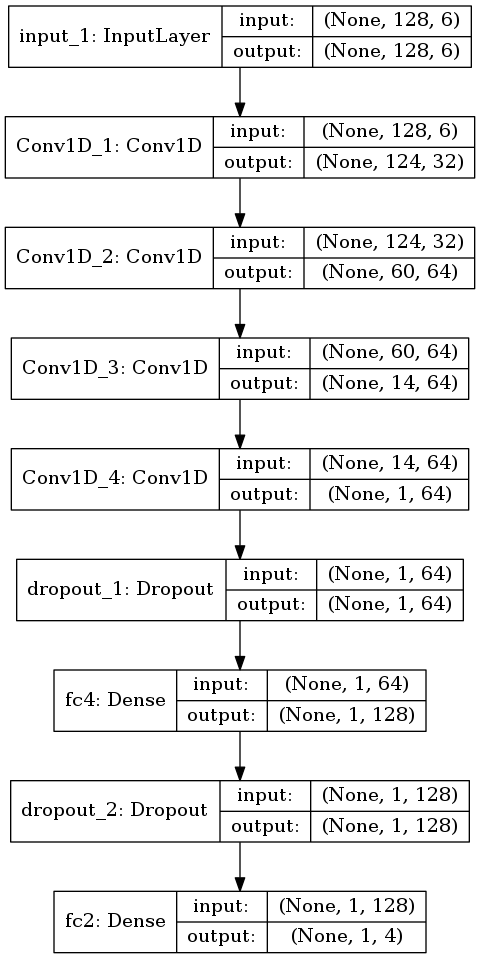

In [49]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
plot_model(harModel, to_file='HappyModel.png',show_shapes=True)

### 4.4 模型对比

| 模型          | F1 score           |
| ------------- | ------------------ |
| SVM           | 0.9661620966845589 |
| Random Forest | 0.9736951801155531 |
| CNN           | 0.9931972622871399 |


**我们的判断指标为F1 score，故选取一维CNN模型**

## 5.动作计数

**在我们选取的4个动作中，每个动作的数据均有较明显的波峰波谷。 针对每个动作，选取其六轴数据中周期特征最明显的一个轴。 并通过实验确定动作周期的阈值**

**实际部署时，手机端一次发送5.12s的数据，共256条数据**

In [ ]:
plt.plot(total_data)

In [219]:
b, a = signal.butter(8, 0.1, 'lowpass') 
fil=["/root/HAR/data/523ios/activity1.json",
     "/root/HAR/data/523ios/activity2.json",
     "/root/HAR/data/523ios/activity3.json",
     "/root/HAR/data/523ios/activity4.json",
      ]
chart_data=[]
label=[]

for filepat in fil:
    
    with open(filepat) as fi:

        for lines in fi:
            
            ones= json.loads(lines)            
            accX=signal.filtfilt(b, a,ones["x_acc"][100:356])                
            accY=signal.filtfilt(b, a,ones["y_acc"][100:356])
            accZ=signal.filtfilt(b, a,ones["z_acc"][100:356])
            gryX=signal.filtfilt(b, a,ones["x_gyr"][100:356])
            gryY=signal.filtfilt(b, a,ones["y_gyr"][100:356])
            gryZ=signal.filtfilt(b, a,ones["z_gyr"][100:356])
                #print(np.dstack((accX,accY,accZ,gryX,gryY,gryZ)).shape)
                         
#               label.append([activity])
            data=list(np.dstack((accX,accY,accZ,gryX,gryY,gryZ)).reshape((256,6)))
            chart_data.append(data)
            #print(data.shape)
        #print(len(one["gryy"][128:256]))
        
        #data.append(json.loads(line))


chart_data=np.array(chart_data)
chart_label=[]

chart_data.shape

(4, 256, 6)

**画出四个动作分别在每个轴上的数据，横向依次为X_acc，Y_acc,Z_acc,X_gyr,Y_gyr,Z_gyr.纵向为徒手侧平举、前后交叉小跑、开合跳、深蹲**


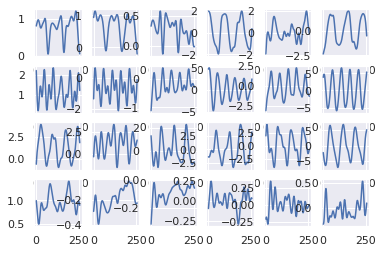

In [220]:
for n in range(24):
    plt.subplot(4,6,n+1)
    action=n//6
    axis=n%6
    plt.plot(chart_data[action,:,axis])


**经过实验，不同动作有不同的运动周期。且在不同的轴上也有较大区别**


| 动作           | 选取轴 | 周期阈值 |
| -------------- | ------ | -------- |
| 徒手侧平举     | Y_acc  | 1300ms   |
| 前后交叉小跑 | X_acc  | 600ms    |
| 开合跳         | Y_acc  | 800ms    |
| 深蹲           | Y_acc  | 1400ms   |

**计数算法**
<img src="https://s1.ax1x.com/2020/06/18/NmSuOs.png" alt="NmSuOs.png" border="0" width=30% />

## 6.服务器部署
### 6.1 配置服务器
####  所需软件/环境
* **基本Python环境**
* **Flask**
* **UWSGI**
* **Nginx**
* **Docker**
* **Tensorflow Serving**
**具体工作流程为**
<img src="https://s1.ax1x.com/2020/06/18/Nm9JsJ.png" alt="Nm9JsJ.png" border="0" width=80%/>


**其中 在DOcker中运行的Tensorflow Serving 可以部署我们之前训练好的模型，并接受Flask客户端发来的数据，并将预测结果返回**

### 服务器代码

**predict 函数的功能为发送数据至Tensorflow Serving 并接收结果

In [ ]:
import os
import time
import string
import random
import json
import requests
import numpy as np
import tensorflow as tf
from detecta import detect_peaks
from scipy import signal
from flask import Flask, request, redirect, url_for, render_template
from flask_bootstrap import Bootstrap
from keras.models import load_model,Model
app = Flask(__name__)
Bootstrap(app)

"""
Constants
"""
MODEL_URI = 'http://localhost:8501/v1/models/firstmodel:predict'
OUTPUT_DIR = 'static'
CLASSES = ['Cat', 'Dog']
SIZE = 128

"""
Utility functions
"""
def predict(json_data):
    total_data=[]
    predict=[]
    if (len(json_data["x_acc"])>=256) & (len(json_data["y_acc"])>=256) &(len(json_data["z_acc"])>=256) &(len(json_data["x_gyr"])>=256) &(len(json_data["y_gyr"])>=256) &(len(json_data["z_gyr"])>=256):
        t=5
    else:
        t=4
   
    b, a = signal.butter(8, 0.2, 'lowpass')
    for i in range(t):
        accX=signal.filtfilt(b, a,json_data["x_acc"][0+i*32:i*32+128])
        accY=signal.filtfilt(b, a,json_data["y_acc"][0+i*32:i*32+128])
        accZ=signal.filtfilt(b, a,json_data["z_acc"][0+i*32:i*32+128])
        gryX=signal.filtfilt(b, a,json_data["x_gyr"][0+i*32:i*32+128])
        gryY=signal.filtfilt(b, a,json_data["y_gyr"][0+i*32:i*32+128])
        gryZ=signal.filtfilt(b, a,json_data["z_gyr"][0+i*32:i*32+128])
        data_one=np.dstack((accX,accY,accZ,gryX,gryY,gryZ)).reshape((128,6))
        total_data.append(data_one)
    total_data=np.array(total_data)
    data=json.dumps({'instances': total_data.tolist()})
    response = requests.post(MODEL_URI, data=data.encode(),timeout=1)
  
    result = json.loads(response.text)
    print(result)
    prediction = result['predictions']
    zzz=np.squeeze(prediction)#np.argmax(yy,1)
    ttt=list(np.argmax(zzz,1))
    pre=np.argmax(np.bincount(ttt))

    print(np.squeeze(pre))
   
    for j in range(len(ttt)):
        ttt[j]=int(ttt[j]) 
    return int(np.squeeze(pre)),ttt


**计数函数**

In [ ]:
def number(json_data,activity):
    data=[]
    b, a = signal.butter(8,0.08, 'lowpass' )
    if activity==0:
        c=signal.filtfilt(b, a,json_data["y_acc"][:256])
        ind = detect_peaks(c,mph=0 ,mpd=65)#动作1 accy 【1】
        return len(ind)
    if activity==1:
        c=signal.filtfilt(b, a,json_data["x_acc"][:256])
        ind = detect_peaks(c,mph=0 ,mpd=30)#动作2 accy 【1】
        return len(ind)
    if activity==2:
        c=signal.filtfilt(b, a,json_data["y_acc"][:256])
        ind = detect_peaks(c,mph=-0.50 ,mpd=40)#动作3 accy 【1】
        return len(ind)
    if activity==3:
        c=signal.filtfilt(b, a,json_data["y_acc"][:256])
        ind = detect_peaks(c ,mpd=70)#动作4 accy 【1】
        return len(ind)

**Flask框架的核心 接受小程序发来的数据，并将结果返回**

In [ ]:
"""
Routes
"""
@app.route('/', methods=['POST'])

def check():
    # 默认返回内容
    return_dict= {'return_code': '200', 'return_info': 'success', 'result': False,'number':'0','all':list([0,0])}
    # 判断传入的json数据是否为空
    if request.get_data() is None:
        return_dict['return_code'] = '5004'
        return_dict['return_info'] = 'empty'
        return json.dumps(return_dict, ensure_ascii=False)
    # 获取传入的参数
    get_Data=request.get_data()
    # 传入的参数需要转化成json
    get_Data=json.loads(get_Data)
    prediction,all_act=predict(get_Data)
    print(type(all_act))
    num=number(get_Data,prediction)
    return_dict['result']=prediction
    return_dict['all']=all_act
    return_dict['number']=int(num)
    # 对参数进行操作
    
 
    return json.dumps(return_dict)


if __name__ == '__main__':
    app.run(host="0.0.0.0",port=5000,threaded=True)



## 7.后期改进
**我们最终选取的算法虽然在测试集上表现良好，但在实际部署中识别结果不一定准确。所以，在小程序中收集了用户 性别、身高、体重等信息。如果识别有误，小程序会统计识别错误用户的信息。以供进一步算法调整**
<img src="https://s1.ax1x.com/2020/06/18/NmizSf.png" alt="NmizSf.png" border="0" width=20%/>

## 8. Reference
<div id="refer-anchor-1"></div>

- [1] [Improving Activity Recognition Accuracy in Ambient-Assisted Living Systems by Automated Feature Engineering](10.1109/ACCESS.2017.2684913)
<div id="refer-anchor-2"></div>

- [2] [How to Model Human Activity From Smartphone Data](https://machinelearningmastery.com/how-to-model-human-activity-from-smartphone-data/)

<div id="refer-anchor-3"></div>

- [3] [Deep learning algorithms for human activity recognition using mobile and wearable sensor networks: State of the art and research challenges](https://www.sciencedirect.com/science/article/abs/pii/S0957417418302136?via%3Dihub)


<div id="refer-anchor-4"></div>

- [4] [Machine Learning Yearning-Andrew Ng](https://www.deeplearning.ai/machine-learning-yearning/)
<div id="refer-anchor-5"></div>

- [5] [Sequential Human Activity Recognition Based on Deep Convolutional Network and Extreme Learning Machine Using Wearable Sensors](https://www.hindawi.com/journals/js/2018/8580959/)


